# ff-QRAM + Grover 演算法範本

使用多控旗標 ancilla + 參數化 RY 門實現 PQC-QRAM，再結合 Grover 搜索。

In [1]:
## 1. 環境與套件匯入
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import MCXGate, CRYGate
from qiskit.visualization import plot_histogram
from qiskit.compiler import transpile
from qiskit_aer import AerSimulator
import numpy as np, random, math
import pkg_resources
print(f"Qiskit: {pkg_resources.get_distribution('qiskit').version}, qiskit-aer: {pkg_resources.get_distribution('qiskit-aer').version}")

Qiskit: 2.0.1, qiskit-aer: 0.17.0


C:\Users\user\AppData\Local\Temp\ipykernel_10100\1268369530.py:8: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [2]:
## 2. 參數與隨機目標
n = 3
N = 2**n
shots = 1024
target_index = random.randrange(N)
memory = [0]*N
memory[target_index] = 1
target_str = format(target_index, f'0{n}b')
print(f"Selected target: {target_index} -> |{target_str}>\n")

Selected target: 0 -> |000>



In [3]:
## 3. PQC-QRAM 建構
# 宣告寄存器
addr = QuantumRegister(n, 'addr')
data = QuantumRegister(1, 'data')
anc  = QuantumRegister(1, 'anc')  # 用於條件旗標
cl   = ClassicalRegister(n, 'cl')
qc   = QuantumCircuit(addr, data, anc, cl)

# 地址超疊加
qc.h(addr)



In [4]:
import math
iterations = int((math.pi / 4) * math.sqrt(2**n))  # Optimal number of iterations
for _ in range(iterations):
    # 3.2 PQC-QRAM: for each j, 計算 AND flag, 再 CRY 加載
    thetas = [math.pi if memory[j]==1 else 0 for j in range(N)]
    for j, theta in enumerate(thetas):
        # prepare matching flag in anc[0]
        for bit in range(n):
            if ((j >> bit) & 1) == 0:
                qc.x(addr[bit])
        qc.mcx(addr, anc[0], ancilla_qubits=[])
        qc.cry(theta, anc[0], data[0])
        qc.mcx(addr, anc[0], ancilla_qubits=[])
        for bit in range(n):
            if ((j >> bit) & 1) == 0:
                qc.x(addr[bit])
    ## 4. Oracle (標記) & QRAM 卸載
    # Oracle: 在 data 上相位翻轉
    qc.z(data[0])

    # 卸載 PQC-QRAM（逆向）
    for j, theta in reversed(list(enumerate(thetas))):
        for bit in range(n):
            if ((j >> bit) & 1) == 0:
                qc.x(addr[bit])
        qc.mcx(addr, anc[0], ancilla_qubits=[])
        qc.cry(-theta, anc[0], data[0])
        qc.mcx(addr, anc[0], ancilla_qubits=[])
        for bit in range(n):
            if ((j >> bit) & 1) == 0:
                qc.x(addr[bit])
    ## 5. 擴散算子 (Diffuser)
    qc.h(addr)
    qc.x(addr)
    qc.h(addr[-1])
    qc.mcx(addr[:-1], addr[-1], ancilla_qubits=[anc[0]])
    qc.h(addr[-1])
    qc.x(addr)
    qc.h(addr)

Analytic success probability: 0.9453, k_opt = 2

Total qubits: 5
Gate counts: OrderedDict({'x': 108, 'mcx': 64, 'cry': 32, 'h': 19, 'measure': 6, 'z': 2, 'ccx': 2})
Circuit depth: 161


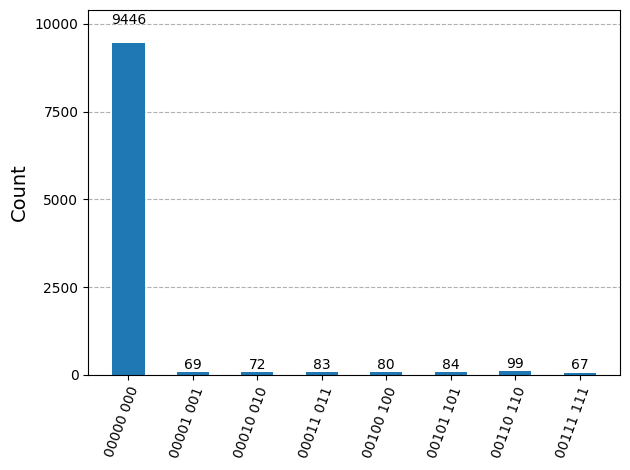

In [6]:
## 6. 測量與解析性評估
qc.measure(addr, cl)
theta0 = math.asin(1/math.sqrt(N))
k_opt = math.floor(math.pi/(4*theta0))
P_theory = math.sin((2*k_opt+1)*theta0)**2
print(f"Analytic success probability: {P_theory:.4f}, k_opt = {k_opt}\n")
print(f"Total qubits: {qc.num_qubits}")
print(f"Gate counts: {qc.count_ops()}")
print(f"Circuit depth: {qc.depth()}")

# 6.3 縮小規模模擬示意
small_shots = 10000
sim_small = AerSimulator()
qc_small = qc.copy()  # 你需要先重建一个 n=3、memory 大小 8 的电路
qc_small.measure_all()
result = sim_small.run(qc_small, shots=small_shots).result()
counts = result.get_counts()
plot_histogram(counts)

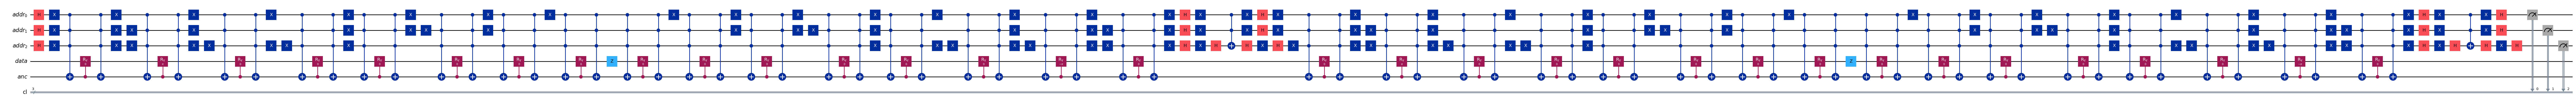

In [12]:
from qiskit.visualization import circuit_drawer

# 使用 Matplotlib 绘制
circuit_drawer(qc, output='mpl', fold=-1)
# 直接在 notebook 里输出 ASCII/Unicode 图
#print(qc.draw('text'))